## Considering new metrics
This notebook contains some code that can be used for performing the computation of the new metrics considered on section 3.3.3

The results of the las experiment (training with LFR and SF) are plotted and the related new metrics are computed

The results considered correspond to the experiments with a 5 graphs training sets

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

### The results obtained when training with 5 graphs are read

In [3]:
with open(f"outputs/real_performance_full_5_generated_train_graphs_15_seeds.pickle",'rb') as f:
    data = pickle.load(f)

### The results obtained are plotted

10000_size
10


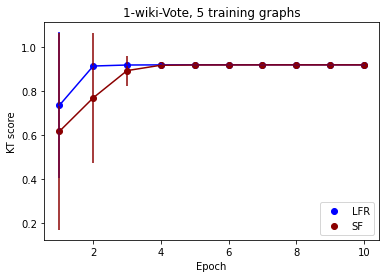

100000_size
10


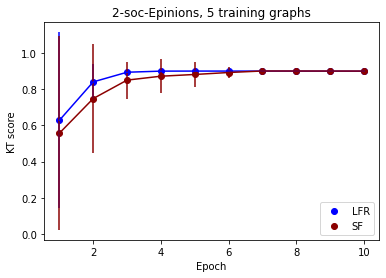

300000_size
10


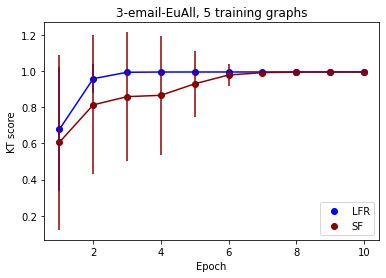

<Figure size 432x288 with 0 Axes>

In [4]:
seeds = range(15)
epochs = range(10)

for graph in ['1-wiki-Vote', '2-soc-Epinions', '3-email-EuAll']:
    size = list(data[graph]['LFR'].keys())[0]
    print(size)
    lfr = data[graph]['LFR'][f'{size}']
    sf = data[graph]['SF'][f'{size}']

    xs = [j for  j in range(1,11)]
    erlfr=[]
    xlfr = []
    ersf = []
    xsf = []
    for epoch in epochs:
        aux_lfr = []
        aux_sf = []
        
        for seed in seeds:
            aux_lfr.append(lfr['1_copies']['pred'][f'{epoch}_epoch'][f'{seed}_seed']['kt'])
            aux_sf.append(sf['1_copies']['pred'][f'{epoch}_epoch'][f'{seed}_seed']['kt'])

        xlfr.append(np.mean(np.array(aux_lfr)))
        erlfr.append(np.std(np.array(aux_lfr)))
        xsf.append(np.mean(np.array(aux_sf)))
        ersf.append(np.std(np.array(aux_sf)))
    print(len(xlfr))
    plt.errorbar(xs,xlfr,erlfr,c='b')
    plt.scatter(xs,xlfr,c='b',label= "LFR")


    plt.errorbar(xs,xsf,ersf,c='darkred')
    plt.scatter(xs,xsf,c='darkred',label = "SF")


    plt.title(f"{graph}, 5 training graphs")
    plt.ylabel("KT score")
    plt.xlabel("Epoch")

    plt.legend(loc=4)
    plt.show()
    plt.clf()
    

### The function for computing the different metrics is defined

In [5]:
import pickle
from scipy.stats import kendalltau,pearsonr

def metrics(pred_results,real_results, graph, positions=[]):

    n = len(pred_results)
    print(f"Number of nodes: {n}")
    assert n == len(real_results)

    nodes_sorted_pred = sorted(range(n),reverse=True,key=lambda k: pred_results[k])
    nodes_sorted_real = sorted(range(n),reverse=True,key=lambda k: real_results[k])
    
    m_dict = {'equal':{},'in_top':{},'pearson':{},'kendall':{}}
    
    if positions == []:
        if graph == '3-email-EuAll':
            percentages = range(1,11)
        else:
            percentages = range(1,101)
        values = []
        for p in percentages:
            values.append(int(p*n/100))
            for k in m_dict.keys():
                m_dict[k][p] = []
    
    else:

        values = positions
        for p in positions:
            for k in m_dict.keys():
                m_dict[k][p] = []

    m_dict['fullkendall'] = kendalltau(pred_results,real_results)

    # nodos igual posicion top
    for idx, p in enumerate(values):
        print(f"Coincident: {idx}",end='\r')
        c = 0
        for j in range(p):
            if nodes_sorted_pred[j] == nodes_sorted_real[j]:
                c += 1
        m_dict['equal'][percentages[idx]].append(round(c/p*100,4))
    print("")

    # nodos acertados top
    for idx, p in enumerate(values):
        print(f"In top: {idx}",end='\r')
        a = sum(1 for item in nodes_sorted_pred[:p] if item in nodes_sorted_real[:p])
        m_dict['in_top'][percentages[idx]].append(round(a/p*100,4))
    print("")
    
    # Pearson correlation
    for idx, p in enumerate(values):
        print(f"Pearson: {idx}",end='\r')
        pear = pearsonr(nodes_sorted_pred[:p],nodes_sorted_real[:p])
        m_dict['pearson'][percentages[idx]].append(pear)
    print("")

    # Kendall
    for idx, p in enumerate(values):
        print(f"kendall: {idx}",end='\r')
        pear = tuple(kendalltau(nodes_sorted_pred[:p],nodes_sorted_real[:p]))
        m_dict['kendall'][percentages[idx]].append(pear)
    print("")


    return m_dict

### The metrics are computed considering the real and predicted betweenness centrality node lists obtained

In [ ]:
M = {}

for graph in ['3-email-EuAll','1-wiki-Vote','2-soc-Epinions']:
    M[graph] = {}

for graph in ['3-email-EuAll','1-wiki-Vote','2-soc-Epinions']:

    for seed in range(15):

        M[graph][seed] = {"SF": {}, "LFR": {}}
        
        size = list(data[graph]['LFR'].keys())[0]
        print(f"Graph: {graph}, size: {size}")

        lfr_real = data[graph]['LFR'][f'{size}']['real']
        lfr_pred = data[graph]['LFR'][f'{size}']['1_copies']['pred'][f'{0}_epoch'][f"{seed}_seed"]['pred']
        sf_real = data[graph]['SF'][f'{size}']['real']
        sf_pred = data[graph]['SF'][f'{size}']['1_copies']['pred'][f'{0}_epoch'][f"{seed}_seed"]['pred']
        
        M[graph][seed]["SF"] = metrics(sf_pred,sf_real,graph=graph)
        
        M[graph][seed]["LFR"] = metrics(lfr_pred,lfr_real,graph=graph)

        with open(f"outputs/metrics_LFR_SF_5_graphs_15_seeds.pickle","wb") as fopen:
            pickle.dump(M,fopen)

### The results are read and plotted

In [5]:
import pickle

with open(f"outputs/metrics_LFR_SF_5_graphs_15_seeds.pickle","rb") as fopen:
    M = pickle.load(fopen)

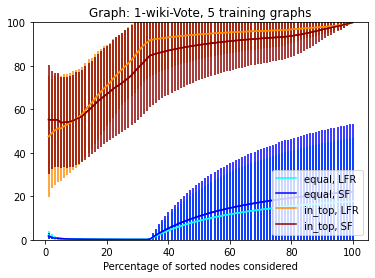

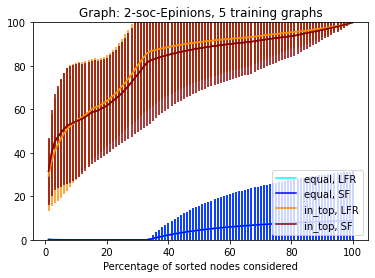

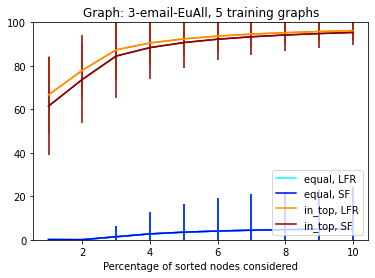

<Figure size 432x288 with 0 Axes>

In [6]:

graphs = ['1-wiki-Vote', '2-soc-Epinions', '3-email-EuAll']
for graph in graphs:
    metric = 'equal'
    gtype = 'LFR'
    color = 'cyan'
    seeds = range(15)
    phasepoint = 33

    xs = [j for j in M[graph][0][gtype][metric].keys()]
    ys = []
    err = []
    for j in xs:
        aux = []
        for seed in seeds:
            aux.append(M[graph][seed][gtype][metric][j])
        ys.append(np.mean(np.array(aux)))
        err.append(np.std(np.array(aux)))
    plt.errorbar(xs,ys,err,c=color)
    plt.plot(xs,ys, c=color, label = f"{metric}, {gtype}")

    metric = 'equal'
    gtype = 'SF'
    color = 'blue'
    seeds = range(15)
    phasepoint = 33

    xs = [j for j in M[graph][0][gtype][metric].keys()]
    ys = []
    err = []
    for j in xs:
        aux = []
        for seed in seeds:
            aux.append(M[graph][seed][gtype][metric][j])
        ys.append(np.mean(np.array(aux)))
        err.append(np.std(np.array(aux)))
    plt.errorbar(xs,ys,err,c=color)
    plt.plot(xs,ys, c=color, label = f"{metric}, {gtype}")


    metric = 'in_top'
    gtype = 'LFR'
    color = 'darkorange'
    seeds = range(15)
    phasepoint = 33

    xs = [j for j in M[graph][0][gtype][metric].keys()]
    ys = []
    err = []
    for j in xs:
        aux = []
        for seed in seeds:
            aux.append(M[graph][seed][gtype][metric][j])
        ys.append(np.mean(np.array(aux)))
        err.append(np.std(np.array(aux)))
    plt.errorbar(xs,ys,err,c=color)
    plt.plot(xs,ys, c=color, label = f"{metric}, {gtype}")

    metric = 'in_top'
    gtype = 'SF'
    color = 'darkred'
    seeds = range(15)
    phasepoint = 33

    xs = [j for j in M[graph][0][gtype][metric].keys()]
    ys = []
    err = []
    for j in xs:
        aux = []
        for seed in seeds:
            aux.append(M[graph][seed][gtype][metric][j])
        ys.append(np.mean(np.array(aux)))
        err.append(np.std(np.array(aux)))
    plt.errorbar(xs,ys,err,c=color)
    plt.plot(xs,ys, c=color, label = f"{metric}, {gtype}")

    plt.title(f'Graph: {graph}, 5 training graphs')
    plt.legend(loc=4)
    plt.ylim(0,100)
    plt.xlabel("Percentage of sorted nodes considered")
    plt.show()
    plt.clf()